In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import jax
import jax.numpy as jnp
from jax import vmap, grad, jit
from jax import random

from gpx.models import GPR
from gpx.kernels import se_kernel
from gpx.utils import softplus, inverse_softplus

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("dark_background")

%load_ext autoreload
%autoreload 2

In [2]:
jax.config.x64_enabled

True

In [3]:
# Generate synthetic data
train_x = jnp.linspace(0, 1, 100)
key = random.PRNGKey(0)
train_y = jnp.sin(train_x * (2 * jnp.pi)) + random.normal(
    key, shape=train_x.shape
) * jnp.sqrt(0.04)
test_x = jnp.linspace(-0.5, 1.5, 51)
test_f = jnp.sin(test_x * (2 * jnp.pi))

train_x = train_x.reshape(-1, 1)
train_y = train_y.reshape(-1, 1)
test_x = test_x.reshape(-1, 1)
test_f = test_f.reshape(-1, 1)

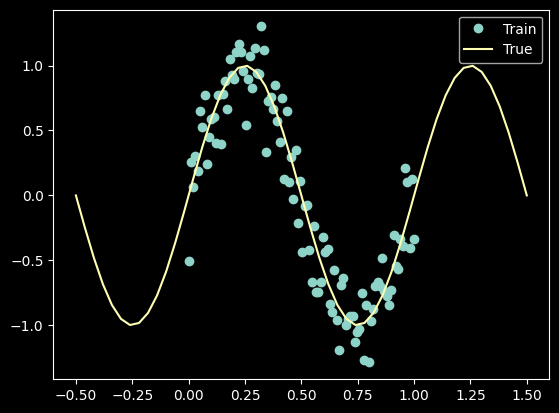

In [4]:
plt.plot(train_x, train_y, "o", label="Train")
plt.plot(test_x, test_f, label="True")
plt.legend()

In [5]:
model = GPR(
    kernel=se_kernel,
    kernel_params={'lengthscale': (1.0, True, softplus, inverse_softplus)},
    sigma=(1.0, True, softplus, inverse_softplus),
)

In [6]:
model.print()

┌────────────────────┬─────────────┬───────────┬──────────────────┬─────────────┬─────────┬─────────┬─────────┐
│ name               │ trainable   │ forward   │ backward         │ type        │ dtype   │ shape   │   value │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼─────────┤
│ kernel lengthscale │ True        │ softplus  │ inverse_softplus │ DeviceArray │ float64 │ ()      │       1 │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼─────────┤
│ sigma              │ True        │ softplus  │ inverse_softplus │ DeviceArray │ float64 │ ()      │       1 │
└────────────────────┴─────────────┴───────────┴──────────────────┴─────────────┴─────────┴─────────┴─────────┘


In [8]:
# Fit using SciPy's L-BFGS-B
model.fit(train_x, train_y)

In [9]:
model.print()

┌────────────────────┬─────────────┬───────────┬──────────────────┬─────────────┬─────────┬─────────┬──────────┐
│ name               │ trainable   │ forward   │ backward         │ type        │ dtype   │ shape   │    value │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼──────────┤
│ kernel lengthscale │ True        │ softplus  │ inverse_softplus │ DeviceArray │ float64 │ ()      │ 0.411059 │
├────────────────────┼─────────────┼───────────┼──────────────────┼─────────────┼─────────┼─────────┼──────────┤
│ sigma              │ True        │ softplus  │ inverse_softplus │ DeviceArray │ float64 │ ()      │ 0.217113 │
└────────────────────┴─────────────┴───────────┴──────────────────┴─────────────┴─────────┴─────────┴──────────┘


In [10]:
# Predict (with full covariance)
yhat, covhat = model.predict(test_x, full_covariance=True)
err = 2 * jnp.diag(covhat) ** 0.5

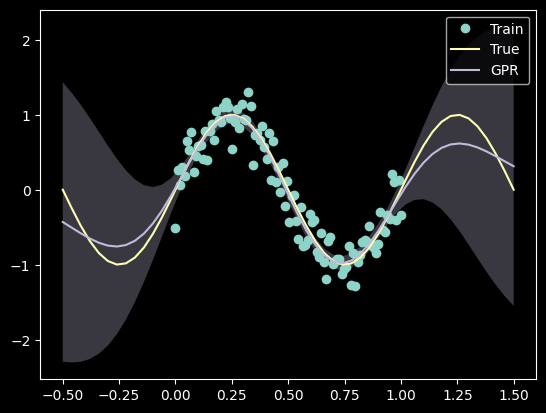

In [11]:
# Plot prediction
plt.plot(train_x, train_y, "o", label="Train", c="C0")
plt.plot(test_x, test_f, label="True", c="C1")
plt.plot(test_x, yhat, label="GPR", c="C2")
plt.fill_between(
    test_x.reshape(-1),
    yhat.reshape(-1) - err,
    yhat.reshape(-1) + err,
    alpha=0.3,
    facecolor="C2",
)
plt.legend()

In [12]:
# Log marginal likelihood
model.log_marginal_likelihood(train_x, train_y, return_negative=True)

DeviceArray(2.23833523, dtype=float64)

In [13]:
# Comparison with GPFlow (if available)
try:

    import gpflow
    from gpflow.utilities import print_summary
    from gpflow.models import GPR as gpf_GPR
    from gpflow.kernels import RBF
    from gpflow.mean_functions import Constant as C
    import numpy as np

    gpf_model = gpf_GPR(
        (np.array(train_x), np.array(train_y)), kernel=RBF(), mean_function=C()
    )
    gpflow.set_trainable(gpf_model.mean_function.c, False)
    gpflow.set_trainable(gpf_model.kernel.variance, False)

    opt = gpflow.optimizers.Scipy()
    opt.minimize(gpf_model.training_loss, gpf_model.trainable_variables)

    # Note that the RBF kernel of gpflow has lengthscale *= 1/np.sqrt(2)
    # Note that is also reports the likelihood variance (sigma ** 2)
    print_summary(gpf_model)
    print(gpf_model.log_marginal_likelihood())


except ModuleNotFoundError:
    pass

2023-03-20 19:51:28.990269: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 19:51:29.935680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-20 19:51:29.935761: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-20 19:51:29.935767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value   │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ False       │ (1,)    │ float64 │ [0.]    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1.0     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.29064 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼────